In [46]:
import pandas as pd
import numpy as np

job_location = r"D:\Users\Will\Tear_Propagation_Project\Convergence"
h = [r"12",r"10",r"08",r"06",r"05",r"04",r"03"]
E_mesh = []
dof = []

for i in range(len(h)):
    job_name = r"Convergence_{val}".format(val=h[i])
    job_path = r"{folder}\{job}".format(folder=job_location,job=job_name)

    inp_file = r"{path}.inp".format(path = job_path)
    with open(inp_file, "r") as file:
        inp = [line.rstrip() for line in file]
        file.close()

    coord_str = tuple(i.split(',') for i in
                      inp[(inp.index('*Node')+1):inp.index('*Element, type=C3D8R')])

    coord = np.array(coord_str, dtype=float)[:,1:]
    num_dof = 3*len(coord)
    dof.append(num_dof)

    Kn = np.zeros((num_dof, num_dof))

    stif_file = r"{path}_STIF2.mtx".format(path = job_path)

    with open(stif_file, "r") as file:
        stif = [line.strip().split() for line in file]
        file.close()

    for line in stif:
        i, j = int(line[0])-1, int(line[1])-1
        val = float(line[2])
        Kn[i,j] = val

    BC_ind = [i for i in range(num_dof) if np.diag(Kn)[i] > 10**30]
    mask = np.ones(len(Kn), dtype=bool)
    mask[BC_ind] = False

    Kc_n = Kn[mask, :]
    Kc_n = Kc_n[:, mask]

    Uc = np.zeros((len(Kc_n),))

    dat_file = r"{path}.dat".format(path = job_path)

    with open(dat_file, "r") as file:
        dat = [line.strip() for line in file]
        file.close()

    U_start = np.array([i for i, x in enumerate(dat) if x == 'NODE FOOT-  U1             U2             U3'])
    U_end = np.array([i for i, x in enumerate(dat) if 
                      (x.startswith('AT NODE') and dat[i-1].startswith('MAXIMUM'))])

    U_start = U_start+3
    U_end = U_end-2

    temp = dat[U_start[-1]:U_end[-1]]
    sep = [x.split()[1:] for x in temp]

    Uc = np.array(sep, dtype=float).flatten()

    uKuT = np.matmul(np.matmul(Uc,Kc_n),Uc.T)
    
    E_mesh.append(uKuT)

dof = np.array(dof)
E_val = np.array(E_mesh)
E_norm = np.array(abs(E_mesh[-1] - E_mesh)/abs(E_mesh[-1]))

In [57]:
print(dof)
print(E_val)
print(E_norm)

[ 5274  8397 12123 18675 28170 46764 79542]
[426.46653764 435.97982832 443.12011354 447.28522858 449.31693304
 451.20347431 450.83630835]
[0.05405459 0.03295316 0.01711529 0.00787665 0.00337013 0.00081441
 0.        ]


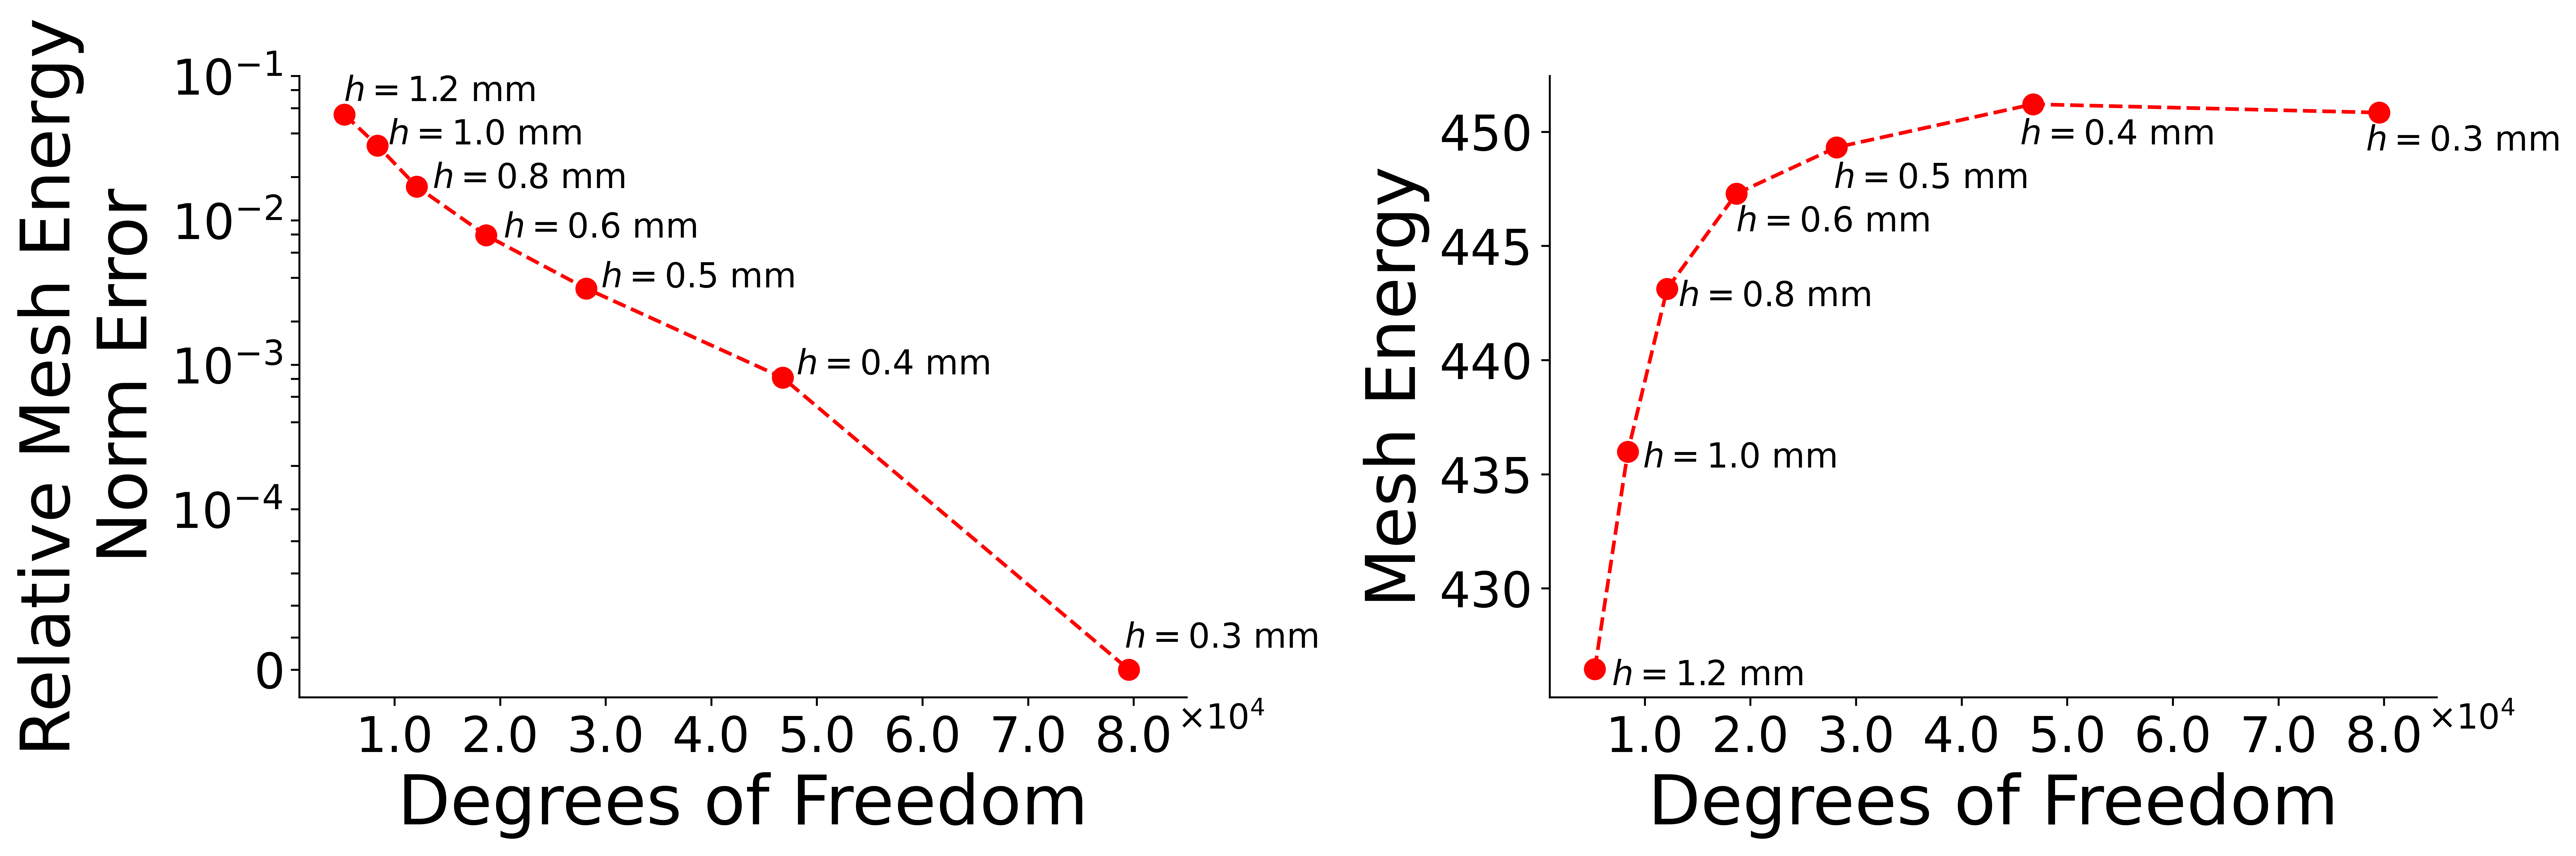

In [94]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=600)

ax[0].plot(dof, E_norm, marker='o', ms=8, mfc='r', mec='r', linestyle='--', color='red')
ax[0].set_yscale('symlog', linthresh=1e-4)
ax[0].set_yticks([0]+[float(f'{x}e-{q}') for x in [2, 4, 6, 8, 10] for q in [5, 4, 3, 2]])

ax[1].plot(dof, E_val, marker='o', ms=8, mfc='r', mec='r', linestyle='--', color='red')#, label=leg)

ax[0].set_ylabel('Relative Mesh Energy\n Norm Error', fontsize=28)
ax[1].set_ylabel('Mesh Energy', fontsize=28)
for c in range(2):
    
    ax[c].set_xlabel('Degrees of Freedom', fontsize=28)
    
    ax[c].set_xticks([float(f'{q}e4') for q in range(1,9)], labels=['{l}.0'.format(l=x) for x in range(1,9)])
    ax[c].set_xlim([1e3, 8.5e4])
    
#     ax[c].set_yticks([float(f'1e-{q}') for q in range(1,7)])
#     ax[c].set_ylim([float(f'5e-7'), float(f'2e-1')])
    #ax[c].legend(loc='best', fontsize=20, ncol=2, markerscale = 1.5, columnspacing=0.8, 
    #         handletextpad=0.1, borderpad=0.3, framealpha=1, edgecolor='black')
    
    for tick in ax[c].xaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    for tick in ax[c].yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
    ax[c].text(0.99, -0.05, r'$\times 10^4$', transform=ax[c].transAxes, size=14)
    ax[c].spines['top'].set_visible(False)
    ax[c].spines['right'].set_visible(False)
#ax[0].set_ylim([-0.0015, 0.011])
ax[0].text(0.05, 0.96, r'$h=1.2$ mm', transform=ax[0].transAxes, size=14)
ax[0].text(0.1, 0.89, r'$h=1.0$ mm', transform=ax[0].transAxes, size=14)
ax[0].text(0.15, 0.82, r'$h=0.8$ mm', transform=ax[0].transAxes, size=14)
ax[0].text(0.23, 0.74, r'$h=0.6$ mm', transform=ax[0].transAxes, size=14)
ax[0].text(0.34, 0.66, r'$h=0.5$ mm', transform=ax[0].transAxes, size=14)
ax[0].text(0.56, 0.52, r'$h=0.4$ mm', transform=ax[0].transAxes, size=14)
ax[0].text(0.93, 0.08, r'$h=0.3$ mm', transform=ax[0].transAxes, size=14)
ax[1].text(0.07, 0.02, r'$h=1.2$ mm', transform=ax[1].transAxes, size=14)
ax[1].text(0.105, 0.37, r'$h=1.0$ mm', transform=ax[1].transAxes, size=14)
ax[1].text(0.145, 0.63, r'$h=0.8$ mm', transform=ax[1].transAxes, size=14)
ax[1].text(0.21, 0.75, r'$h=0.6$ mm', transform=ax[1].transAxes, size=14)
ax[1].text(0.32, 0.82, r'$h=0.5$ mm', transform=ax[1].transAxes, size=14)
ax[1].text(0.53, 0.89, r'$h=0.4$ mm', transform=ax[1].transAxes, size=14)
ax[1].text(0.92, 0.88, r'$h=0.3$ mm', transform=ax[1].transAxes, size=14)
fig.tight_layout(pad=2.0)
fig.savefig('Convergence_Study_Tear_Propagation_Project_Dorsal.eps')